#[Parameter efficient tuning using LORA](https://arxiv.org/pdf/2106.09685.pdf)

LoRA is a relatively new technique for adapting LLMs to specific downstream tasks. LoRA works by freezing the pre trained model weights and and injecting trainable rank decomposition matrices into each layer of the transformer architecture. This greatly reduces the number of trainable parameters required, and hence reducing the resources required i.e. reduced memory usage while training, and reduced disk space for checkpoints. This allows for fine tuning of relatively large models using basic hardware. This example uses [huggingface PEFT](https://huggingface.co/docs/diffusers/training/lora) libraries that use the LORA technique for parameter efficient fine tuning of Roberta-Large (355M parameters).

This work is built on the premise that pre trained models have a low intrinsic "rank" i.e. The number of linearly independent rows or columns. Therefore it follow that changes in these pre trained weights as a result of task specific fune tuning must also has a low intrinsic rank.

Assuming the base model weights to be $W_ox$ and $\varDelta Wx$ to be the changes due to fine tuning, then the fine tuned weights can be expressed as $h=Wox+\varDelta Wx$. Further the LoRA adapters create a low rank decomposition $\varDelta Wx = BA$ resulting in $h=W_0x+BAx$

Concrete example:
If a weight matrix is of size = $d=5000$, $k=3000$, $d \times k = 15,000,000$ parameters; using $r=6$ we get $(d \times r) + (r \times k) = 30000 + 18000 = 48,000$ parameters, which is 0.3% of the size



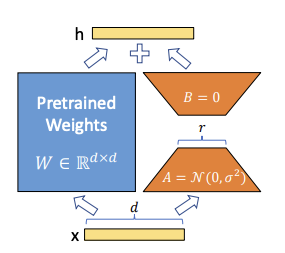

In [ ]:
!pip install datasets
!pip install transformers[torch]
!pip install evaluate
!pip install peft
!pip install accelerate

In [ ]:
from datasets import load_dataset, load_metric
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
)
from peft import get_peft_config, PeftModel, PeftConfig, get_peft_model, LoraConfig, TaskType
import evaluate
import torch
import numpy as np

model_checkpoint = "roberta-large"
lr = 1e-5
batch_size = 8
num_epochs = 2


### Set LORA specific hyperparameters

`r` is the rank of the

In [ ]:
r = 8
lora_alpha = 32
lora_dropout = 0.1

## Load IMDB Dataset
reduce dataset size to 10K to reduce tuning time

In [ ]:
imdb = load_dataset("imdb")
for key in imdb.keys():
    imdb[key] = imdb[key].shuffle().select((range(10000)))


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

## This function gets used during evaluation

In [ ]:
from datasets import list_metrics
metric = load_metric('accuracy')

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)


<ipython-input-6-c5771e289de9>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('accuracy')


## Tokenize input text

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
def tokenize(examples):
    tokenized_inputs = tokenizer(examples["text"], truncation=True, padding="max_length", max_length=512)

    return tokenized_inputs


In [ ]:
tokenized_imdb = imdb.map(tokenize, batched=True)


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

## Load classification model.

`AutoModelForSequenceClassification` is a Generic huggingface transformers library that has a classification head on top of model outputs. We freeze the model layers explicitly since the LORA adapters will be used to train smaller weight matrices

In [ ]:
id2label = {
    0: "neg",
    1: "pos"
}

label2id = {
    "neg": 0,
    "pos": 1
}

model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=2, id2label=id2label, label2id=label2id
)
for name, param in model.named_parameters():
    param.requires_grad = False

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## LORA setup
setup the lora config and call function to get the peft version of the model that adds the extra adapters and layers

In [ ]:
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, inference_mode=False, r=r, lora_alpha=lora_alpha, lora_dropout=lora_dropout
)

In [ ]:
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()


trainable params: 2,889,732 || all params: 357,199,876 || trainable%: 0.8089958015550934


In [ ]:
_= model.to("cuda")

## Setup training arguments and train model

In [ ]:
training_args = TrainingArguments(
    output_dir="roberta-large-lora-sequence-classification",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=10,
    load_best_model_at_end=True,
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_imdb["train"],
    eval_dataset=tokenized_imdb["test"],
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.166400,0.224950,0.950800
2,0.309200,0.222165,0.952700


TrainOutput(global_step=2500, training_loss=0.28571542048975823, metrics={'train_runtime': 6771.8939, 'train_samples_per_second': 2.953, 'train_steps_per_second': 0.369, 'total_flos': 1.875155902464e+16, 'train_loss': 0.28571542048975823, 'epoch': 2.0})

## Run a sample evaluation

In [ ]:
#Run an example inference on a few rows in test dataset
examples = tokenized_imdb["test"].select(range(5))
result = trainer.predict(examples)
for ex, pred in zip(examples, result.label_ids):
    print(ex['text'][:150], id2label[pred])






To even say that this film is Sebastien's work at his best just tell you everything you have to know on the man. Sebastien is a pathetic, foolish, not neg
This is one of the movies one has to start watching with an open mind. One knows it's going to about a mute, one could look forward to or be afraid fo pos
Can I just start by saying I'm a fan of bad movies. And this is a really bad movie. It states on the front 100 passengers, 3000 snakes, but I think it neg
This movie is one of the worst remakes I have ever seen in my life! The acting is laughable and Corman has not improved his piranhas any since 1978. 9 neg
There are movies that are leaders, and movies that are followers.<br /><br />"Meatballs" was a leader. And here's one of its followers.<br /><br />"Pa neg


## Size of checkpoints

In [ ]:
# print and check size of checkpoint. As expected the model size is much smaller that a typical bert checkpoint
!ls -lh roberta-large-lora-sequence-classification/checkpoint-1250/


total 22M
-rw-r--r-- 1 root root  430 Sep 17 12:40 adapter_config.json
-rw-r--r-- 1 root root 7.1M Sep 17 12:40 adapter_model.bin
-rw-r--r-- 1 root root  15M Sep 17 12:40 optimizer.pt
-rw-r--r-- 1 root root   88 Sep 17 12:40 README.md
-rw-r--r-- 1 root root  15K Sep 17 12:40 rng_state.pth
-rw-r--r-- 1 root root  627 Sep 17 12:40 scheduler.pt
-rw-r--r-- 1 root root  15K Sep 17 12:40 trainer_state.json
-rw-r--r-- 1 root root 4.0K Sep 17 12:40 training_args.bin
